Data testing loaded: 2000 rows
Columns: ['fw_load_avg_1_min', 'fw_load_avg_5_min', 'fw_load_avg_15_min', 'fw_cpu_used', 'mem_used', 'root_used', 'log_used', 'fw_total_alloc', 'total_rx_packets', 'total_tx_packets', 'created_at']
Date range: 2024-11-06 08:01:10.657000 to 2024-11-09 02:39:52.147000
✅ Model anti-overfitting berhasil dimuat
✅ Scaler anti-overfitting berhasil dimuat
✅ Thresholds anti-overfitting berhasil dimuat
   - Window size: 10
   - Threshold (95th percentile): 0.080026
   - Q75 threshold: 0.075959

=== PREPROCESSING ===
Original shape: (2000, 10)
Scaled shape: (2000, 10)
Scaled range: [0.052, 0.932]
10
Sequences created: (1991, 10, 10)

=== PREDICTING ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
MSE statistics:
  Mean: 0.051628
  Std: 0.002316
  Min: 0.045882
  Max: 0.058470
  Threshold: 0.080026

=== THRESHOLD LEVELS ===
Low sensitivity (75th percentile): 0.075959
Medium sensitivity (95th percentile): 0.080026
High sensitivity (99th percentile): 0.056676

=== ANOMALY DE

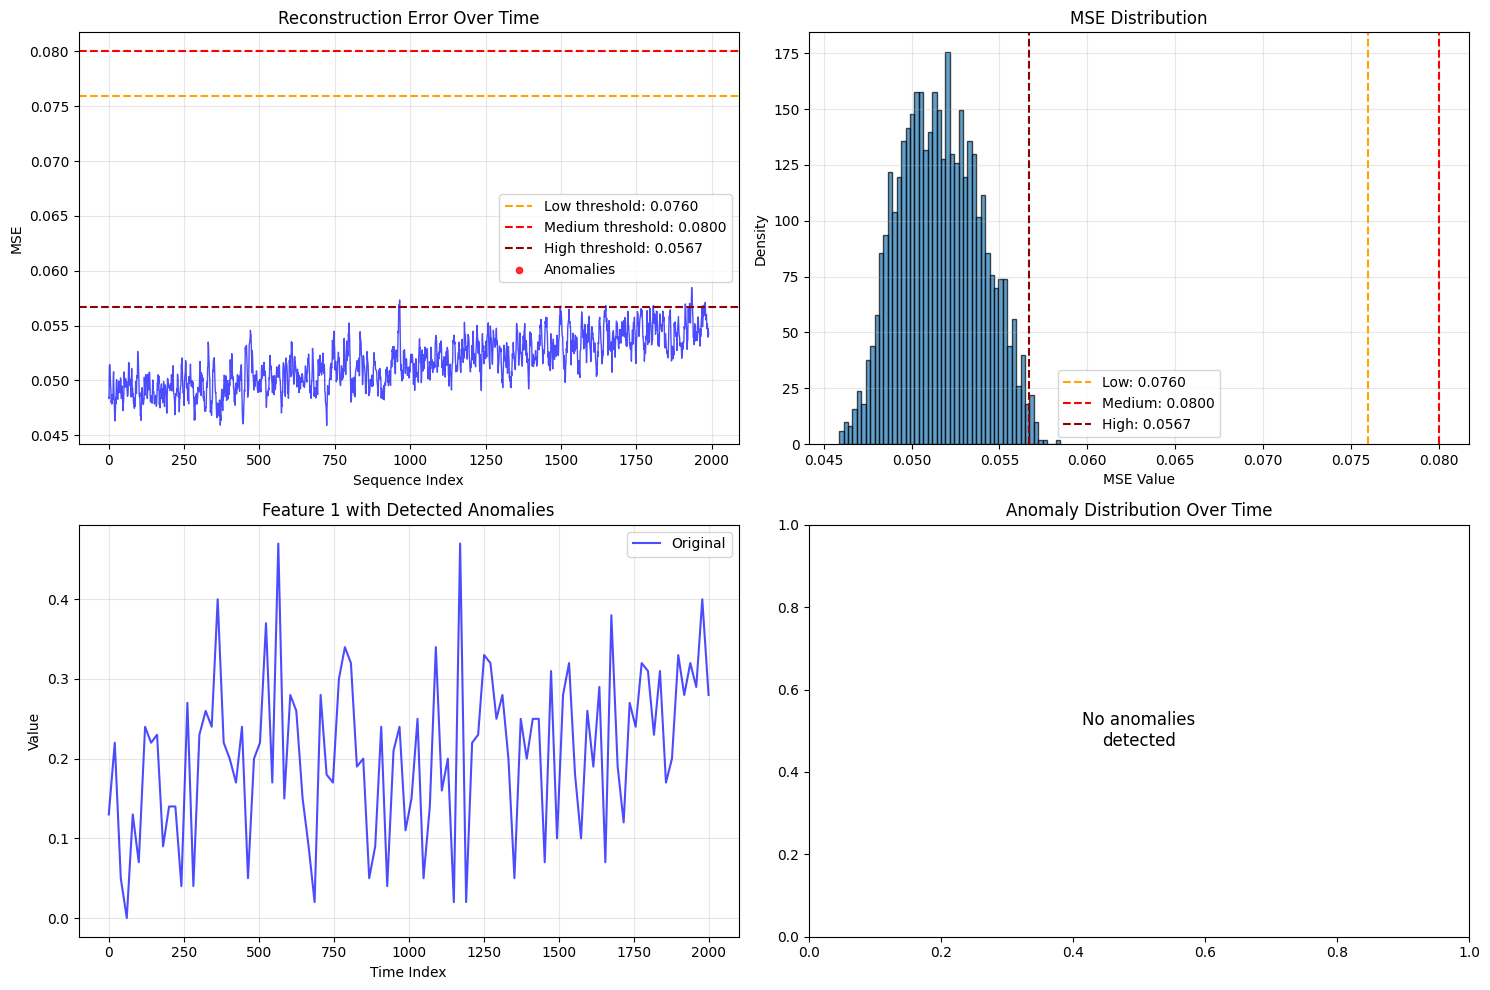


=== SAVING RESULTS ===
✅ anomaly_high_sensitivity.csv saved
✅ anomaly_detection_summary.pkl saved

=== SUMMARY ===
Total data points: 2000
Total sequences: 1991
Anomalies detected (medium): 0 rows (0.00%)
MSE range: [0.045882, 0.058470]
Threshold used: 0.080026

🎯 Anomaly detection completed successfully!


In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load data testing
df_new = pd.read_csv('system_monitoring_unsupervised.csv', sep=';', decimal=',')
df_new['created_at'] = pd.to_datetime(df_new['created_at'])
numeric_new_df = df_new.drop(columns=['created_at'])
numeric_new = numeric_new_df.values

print(f"Data testing loaded: {len(df_new)} rows")
print(f"Columns: {list(df_new.columns)}")
print(f"Date range: {df_new['created_at'].min()} to {df_new['created_at'].max()}")

# Load model dan artifacts yang baru (anti-overfitting)
try:
    model = load_model('lstm_autoencoder_anti_overfit.keras')
    print("✅ Model anti-overfitting berhasil dimuat")
except:
    print("❌ Model anti-overfitting tidak ditemukan, menggunakan model lama")
    model = load_model('lstm_autoencoder.keras')

# Load scaler yang baru
try:
    with open('scaler_anti_overfit.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Scaler anti-overfitting berhasil dimuat")
except:
    print("❌ Scaler anti-overfitting tidak ditemukan, menggunakan scaler lama")
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

# Load thresholds yang baru
try:
    with open('thresholds_anti_overfit.pkl', 'rb') as f:
        data_thresh = pickle.load(f)
    threshold = data_thresh['threshold']
    window_size = data_thresh['window_size']
    q75_val = data_thresh['q75_val']
    q95_val = data_thresh['q95_val']
    print("✅ Thresholds anti-overfitting berhasil dimuat")
    print(f"   - Window size: {window_size}")
    print(f"   - Threshold (95th percentile): {threshold:.6f}")
    print(f"   - Q75 threshold: {q75_val:.6f}")
    
except:
    print("❌ Thresholds anti-overfitting tidak ditemukan, menggunakan threshold lama")
    with open('thresholds.pkl', 'rb') as f:
        data_thresh = pickle.load(f)
    threshold = data_thresh['threshold']
    window_size = data_thresh['window_size']

# Preprocessing data testing (sesuai dengan model anti-overfitting)
scaled_new = scaler.transform(numeric_new)
# Tidak menggunakan log transform karena model baru tidak pakai log
data_final_new = scaled_new

print(f"\n=== PREPROCESSING ===")
print(f"Original shape: {numeric_new.shape}")
print(f"Scaled shape: {scaled_new.shape}")
print(f"Scaled range: [{scaled_new.min():.3f}, {scaled_new.max():.3f}]")

# Check apakah data cukup untuk window
if len(data_final_new) < window_size:
    print(f"❌ Data testing hanya {len(data_final_new)} baris, butuh minimal {window_size}")
    exit()

def create_sliding_windows(array, window_size):
    sequences = []
    for i in range(len(array) - window_size + 1):
        sequences.append(array[i: i + window_size])
    return np.array(sequences)

# Create sequences
print('===================')
print(window_size)
print('===================')
sequences_new = create_sliding_windows(data_final_new, window_size)
print(f"Sequences created: {sequences_new.shape}")

# Predict dan hitung reconstruction error
print(f"\n=== PREDICTING ===")
pred_new = model.predict(sequences_new, batch_size=256, verbose=1)
mse_new = np.mean(np.square(sequences_new - pred_new), axis=(1, 2))

print(f"MSE statistics:")
print(f"  Mean: {np.mean(mse_new):.6f}")
print(f"  Std: {np.std(mse_new):.6f}")
print(f"  Min: {np.min(mse_new):.6f}")
print(f"  Max: {np.max(mse_new):.6f}")
print(f"  Threshold: {threshold:.6f}")

# Deteksi anomali dengan berbagai tingkat sensitivitas
# Menggunakan percentile-based thresholds yang lebih robust
threshold_low = q75_val if 'q75_val' in locals() else np.percentile(mse_new, 75)
threshold_medium = threshold  
threshold_high = np.percentile(mse_new, 99)

print(f"\n=== THRESHOLD LEVELS ===")
print(f"Low sensitivity (75th percentile): {threshold_low:.6f}")
print(f"Medium sensitivity (95th percentile): {threshold_medium:.6f}")
print(f"High sensitivity (99th percentile): {threshold_high:.6f}")

# Deteksi anomali
idx_anom_low = np.where(mse_new > threshold_low)[0]
idx_anom_medium = np.where(mse_new > threshold_medium)[0]
idx_anom_high = np.where(mse_new > threshold_high)[0]

print(f"\n=== ANOMALY DETECTION RESULTS ===")
print(f"Low sensitivity anomalies: {len(idx_anom_low)}")
print(f"Medium sensitivity anomalies: {len(idx_anom_medium)}")
print(f"High sensitivity anomalies: {len(idx_anom_high)}")

def map_window_to_rows(win_idxs, window_size):
    """Map window indices to original row indices"""
    rows = set()
    for seq_idx in win_idxs:
        for j in range(seq_idx, seq_idx + window_size):
            if j < len(df_new):
                rows.add(j)
    return sorted(list(rows))

# Map ke baris asli
rows_anom_low = map_window_to_rows(idx_anom_low, window_size)
rows_anom_medium = map_window_to_rows(idx_anom_medium, window_size)
rows_anom_high = map_window_to_rows(idx_anom_high, window_size)

# Buat DataFrame anomali
df_anom_low = df_new.iloc[rows_anom_low].copy() if rows_anom_low else pd.DataFrame()
df_anom_medium = df_new.iloc[rows_anom_medium].copy() if rows_anom_medium else pd.DataFrame()
df_anom_high = df_new.iloc[rows_anom_high].copy() if rows_anom_high else pd.DataFrame()

# Tambahkan MSE score untuk context
if not df_anom_medium.empty:
    # Ambil MSE score untuk setiap baris (approximate)
    mse_scores = []
    for idx in rows_anom_medium:
        # Find which sequences contain this row
        relevant_mse = []
        for seq_idx, seq_start in enumerate(range(len(df_new) - window_size + 1)):
            if seq_start <= idx < seq_start + window_size:
                relevant_mse.append(mse_new[seq_idx])
        mse_scores.append(np.mean(relevant_mse) if relevant_mse else 0)
    
    df_anom_medium['mse_score'] = mse_scores
    df_anom_medium = df_anom_medium.sort_values('mse_score', ascending=False)

# Display hasil
print(f"\n=== ANOMALI TERDETEKSI (MEDIUM SENSITIVITY) ===")
if not df_anom_medium.empty:
    print(f"Total anomali: {len(df_anom_medium)}")
    print(f"Periode anomali: {df_anom_medium['created_at'].min()} to {df_anom_medium['created_at'].max()}")
    print("\nTop 10 anomali dengan MSE tertinggi:")
    display_cols = ['created_at', 'mse_score'] + [col for col in df_anom_medium.columns if col not in ['created_at', 'mse_score']]
    print(df_anom_medium[display_cols].head(10).to_string(index=False))
else:
    print("Tidak ada anomali terdeteksi dengan threshold medium")

print(f"\n=== ANOMALI TERDETEKSI (HIGH SENSITIVITY) ===")
if not df_anom_high.empty:
    print(f"Total anomali: {len(df_anom_high)}")
    print(f"Periode anomali: {df_anom_high['created_at'].min()} to {df_anom_high['created_at'].max()}")
    print("\nSample anomali dengan confidence tinggi:")
    print(df_anom_high.head(5).to_string(index=False))
else:
    print("Tidak ada anomali terdeteksi dengan threshold tinggi")

# Visualisasi
plt.figure(figsize=(15, 10))

# Plot 1: MSE over time
plt.subplot(2, 2, 1)
plt.plot(range(len(mse_new)), mse_new, 'b-', alpha=0.7, linewidth=1)
plt.axhline(y=threshold_low, color='orange', linestyle='--', label=f'Low threshold: {threshold_low:.4f}')
plt.axhline(y=threshold_medium, color='red', linestyle='--', label=f'Medium threshold: {threshold_medium:.4f}')
plt.axhline(y=threshold_high, color='darkred', linestyle='--', label=f'High threshold: {threshold_high:.4f}')
plt.scatter(idx_anom_medium, mse_new[idx_anom_medium], color='red', s=20, alpha=0.8, label='Anomalies')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Sequence Index')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: MSE distribution
plt.subplot(2, 2, 2)
plt.hist(mse_new, bins=50, alpha=0.7, edgecolor='black', density=True)
plt.axvline(threshold_low, color='orange', linestyle='--', label=f'Low: {threshold_low:.4f}')
plt.axvline(threshold_medium, color='red', linestyle='--', label=f'Medium: {threshold_medium:.4f}')
plt.axvline(threshold_high, color='darkred', linestyle='--', label=f'High: {threshold_high:.4f}')
plt.title('MSE Distribution')
plt.xlabel('MSE Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Feature comparison (contoh: feature pertama)
plt.subplot(2, 2, 3)
if len(numeric_new) > 100:  # Sample jika data terlalu banyak
    sample_idx = np.linspace(0, len(numeric_new)-1, 100, dtype=int)
    plt.plot(sample_idx, numeric_new[sample_idx, 0], 'b-', alpha=0.7, label='Original')
    
    # Highlight anomalous points
    anom_in_sample = [i for i in rows_anom_medium if i in sample_idx]
    if anom_in_sample:
        anom_sample_idx = [np.where(sample_idx == i)[0][0] for i in anom_in_sample]
        plt.scatter([sample_idx[i] for i in anom_sample_idx], 
                   [numeric_new[sample_idx[i], 0] for i in anom_sample_idx], 
                   color='red', s=30, alpha=0.8, label='Anomalies')
else:
    plt.plot(range(len(numeric_new)), numeric_new[:, 0], 'b-', alpha=0.7, label='Original')
    if rows_anom_medium:
        plt.scatter(rows_anom_medium, numeric_new[rows_anom_medium, 0], 
                   color='red', s=30, alpha=0.8, label='Anomalies')

plt.title(f'Feature 1 with Detected Anomalies')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Anomaly timeline
plt.subplot(2, 2, 4)
if not df_anom_medium.empty:
    anomaly_counts = df_anom_medium.set_index('created_at').resample('1H').size()
    anomaly_counts.plot(kind='bar', alpha=0.7)
    plt.title('Anomaly Distribution Over Time')
    plt.xlabel('Time')
    plt.ylabel('Anomaly Count')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No anomalies\ndetected', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Anomaly Distribution Over Time')

plt.tight_layout()
plt.show()

# Save results
print(f"\n=== SAVING RESULTS ===")

# Save anomali dengan berbagai sensitivitas
if not df_anom_low.empty:
    df_anom_low.to_csv('anomaly_low_sensitivity.csv', index=False, sep=';', decimal=',')
    print("✅ anomaly_low_sensitivity.csv saved")

if not df_anom_medium.empty:
    df_anom_medium.to_csv('anomaly_medium_sensitivity.csv', index=False, sep=';', decimal=',')
    print("✅ anomaly_medium_sensitivity.csv saved")

if not df_anom_high.empty:
    df_anom_high.to_csv('anomaly_high_sensitivity.csv', index=False, sep=';', decimal=',')
    print("✅ anomaly_high_sensitivity.csv saved")

# Save summary
summary_data = {
    'threshold_low': threshold_low,
    'threshold_medium': threshold_medium, 
    'threshold_high': threshold_high,
    'total_sequences': len(sequences_new),
    'anomalies_low': len(idx_anom_low),
    'anomalies_medium': len(idx_anom_medium),
    'anomalies_high': len(idx_anom_high),
    'mse_mean': np.mean(mse_new),
    'mse_std': np.std(mse_new),
    'mse_min': np.min(mse_new),
    'mse_max': np.max(mse_new)
}

with open('anomaly_detection_summary.pkl', 'wb') as f:
    pickle.dump(summary_data, f)

print("✅ anomaly_detection_summary.pkl saved")
print(f"\n=== SUMMARY ===")
print(f"Total data points: {len(df_new)}")
print(f"Total sequences: {len(sequences_new)}")
print(f"Anomalies detected (medium): {len(rows_anom_medium)} rows ({len(rows_anom_medium)/len(df_new)*100:.2f}%)")
print(f"MSE range: [{np.min(mse_new):.6f}, {np.max(mse_new):.6f}]")
print(f"Threshold used: {threshold_medium:.6f}")

print("\n🎯 Anomaly detection completed successfully!")